In [16]:
# import importlib
# import preprocess_data.process_ground_truth
# importlib.reload(preprocess_data.process_ground_truth)
# from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep

In [52]:
import json
import numpy as np
from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from hyperopt import hp, fmin, tpe, Trials
from tensorflow.keras.optimizers import Adam
import os
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
os.chdir('/Users/ruotsing/PycharmProjects/DMS')

with open('preprocess_data/lateral_acceleration_data.json', 'r') as f:
    LA_data = json.load(f)
    
with open('preprocess_data/SWA_data.json', 'r') as f:
    SWA_data = json.load(f)

with open('preprocess_data/lateral_displacement_data.json', 'r') as f:
    LD_data = json.load(f)
    
with open('preprocess_data/YA_data.json', 'r') as f:
    YA_data = json.load(f)
    
with open('preprocess_data/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
    
def time_derivative(data, time_interval):
    data_dt = {}
    for name in data.keys():
        delta_displacement = np.diff(data[name])
        data_dt[name] = np.gradient(delta_displacement, time_interval)
    return data_dt

def simulate_decrease_sample_rate_regular(data,original_rate,target_rate):
    processed_data = {}
    for name in data.keys():
        processed_data[name] = []
        for i in range(0, len(data[name]), int(original_rate/target_rate)):
            processed_data[name].append(data[name][i])
    return processed_data

original_sample_rate = 100
target_sample_rate = 30

LA_data = simulate_decrease_sample_rate_regular(LA_data, original_sample_rate, target_sample_rate)
SWA_data = simulate_decrease_sample_rate_regular(SWA_data, original_sample_rate, target_sample_rate)
LD_data = simulate_decrease_sample_rate_regular(LD_data, original_sample_rate, target_sample_rate)
YA_data = simulate_decrease_sample_rate_regular(YA_data, original_sample_rate, target_sample_rate)

sample_rate = target_sample_rate
SWV_data= time_derivative(SWA_data, 1/sample_rate)
YR_data= time_derivative(YA_data, 1/sample_rate)

#standardize the data within every driver
def standardize(data):
    data_standard = {}
    for name in data.keys():
        data_standard[name] = (data[name] - np.mean(data[name]))/np.std(data[name])
    return data_standard

YR_standard = standardize(YR_data)
SWA_standard = standardize(SWA_data)
SWV_standard = standardize(SWV_data)
LD_standard = standardize(LD_data)
LA_standard = standardize(LA_data)

#apply the time window
size_= 10
step = 1
ground_truth=reform_ground_truth(ground_truth)
awake_window, light_drowsy_window, drowsy_window,general_window=ground_truth_sep(ground_truth,size_,step)

def define_feature_matrix(awake_window, light_drowsy_window, drowsy_window,general_window, data):
    feature_matrix = {}
    label = {}
    for name in general_window.keys():
        feature_matrix[name] = []
        label[name] = []
        for i in range(len(general_window[name])):
            begin = general_window[name][i][0]*sample_rate
            end = (general_window[name][i][-1]+1)*sample_rate
            feature_matrix[name].append(data[name][begin:end])
            if tuple(general_window[name][i]) in awake_window[name]:
                label[name].append(0)
            if tuple(general_window[name][i]) in light_drowsy_window[name]:
                label[name].append(1)
            if tuple(general_window[name][i]) in drowsy_window[name]:
                label[name].append(2)
        feature_matrix[name]=np.array(feature_matrix[name])        
        label[name]=np.array(label[name])
    return feature_matrix, label
   
YR_feature_matrix, label = define_feature_matrix(awake_window, light_drowsy_window, drowsy_window,general_window, YR_standard)
SWA_feature_matrix, _ = define_feature_matrix(awake_window, light_drowsy_window, drowsy_window,general_window, SWA_standard)
SWV_feature_matrix, _ = define_feature_matrix(awake_window, light_drowsy_window, drowsy_window,general_window, SWV_standard)
LD_feature_matrix, _ = define_feature_matrix(awake_window, light_drowsy_window, drowsy_window,general_window, LD_standard)
LA_feature_matrix, _ = define_feature_matrix(awake_window, light_drowsy_window, drowsy_window,general_window, LA_standard)

feature_matrix = {}
for name in YR_feature_matrix.keys():
    # feature_matrix[name]=np.dstack((YR_feature_matrix[name], SWA_feature_matrix[name], SWV_feature_matrix[name], LD_feature_matrix[name], LA_feature_matrix[name]))
    feature_matrix[name]=np.dstack((SWA_feature_matrix[name], SWV_feature_matrix[name]))
    
    
def prepare_input(feature_matrix, label,drivers):
    result_matrix=np.empty((0,feature_matrix[drivers[0]].shape[1],feature_matrix[drivers[0]].shape[2]))
    result_label=np.empty((0,))
    for name in drivers:
        result_matrix=np.concatenate((result_matrix,feature_matrix[name]),axis=0)
        result_label=np.concatenate((result_label,label[name]),axis=0)
        
    return result_matrix, result_label    

drivers_train= ['catia', 'giulio', 'vasanth', 'emanuele', 'michele', 'stefano']
drivers_test = ['gea']

X_train, y_train = prepare_input(feature_matrix, label, drivers_train)
y_train = y_train.astype(int)
X_rest, y_rest = prepare_input(feature_matrix, label, drivers_test)
y_rest = y_rest.astype(int)
split_point = int(len(X_rest)/2)
X_val=X_rest[:split_point]
y_val=y_rest[:split_point]
X_test=X_rest[split_point:]
y_test=y_rest[split_point:]

In [54]:

def make_model(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=space['learning_rate'][best_params['learning_rate']]), loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=list(class_weight_dict.values()), gamma=2.0), metrics=['categorical_accuracy'])
    return model

def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    y_pred=[]
    for row in model.predict(X_test):
        y_pred.append(np.argmax(row))
    y_pred=np.array(y_pred)    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()

In [55]:

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


In [32]:

    
space = {
    'conv_filters_1': hp.choice('conv_filters_1', [32, 64, 128]),
    'conv_filters_2': hp.choice('conv_filters_2', [32, 64, 128]),
    'conv_filters_3': hp.choice('conv_filters_3', [32, 64, 128]),
    'conv_filters_4': hp.choice('conv_filters_4', [32, 64, 128]),
    'mini_batch_size': hp.choice('mini_batch_size', [32, 64, 128]),
    'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01]),
    'pooling_size_hyperopt': hp.choice('pooling_size_hyperopt', [2,3]),
    'neurons_lstm': hp.choice('neurons_lstm', [32, 64, 128]),
    'neurons_gru': hp.choice('neurons_gru', [32, 64, 128])
}

space_params = {
    'conv_filters_1': [32, 64, 128],
    'conv_filters_2': [32, 64, 128],
    'conv_filters_3': [32, 64, 128],
    'conv_filters_4': [32, 64, 128],
    'learning_rate': [0.001, 0.005, 0.01],
    'mini_batch_size': [32, 64, 128],
    'pooling_size_hyperopt': [2,3],
    'neurons_lstm': [32, 64, 128],
    'neurons_gru': [32, 64, 128]
}    

In [ ]:
def objective(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=list(class_weight_dict.values()), gamma=2.0), metrics=['categorical_accuracy'])
    
    model.fit(X_train, y_train_one_hot, epochs=100, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val_one_hot), verbose=0, callbacks=[early_stopping])
    
    f1=f1_score(y_val, model.predict(X_val,verbose=0).argmax(axis=1), average='weighted')
    return -f1  # Hyperopt minimizes the objective function

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=3)
trials = Trials()
best_params_weighted = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best hyperparameters:", best_params_weighted)

best_weighted_model = make_model(space_params, best_params_weighted)
best_weighted_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=space_params['mini_batch_size'][best_params_weighted['mini_batch_size']], validation_data=(X_val, y_val_one_hot), verbose=0, callbacks=[early_stopping])
confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_test, y_test)

  6%|▌         | 3/50 [06:47<1:31:32, 116.86s/trial, best loss: -0.4439513799290768]

660/660 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


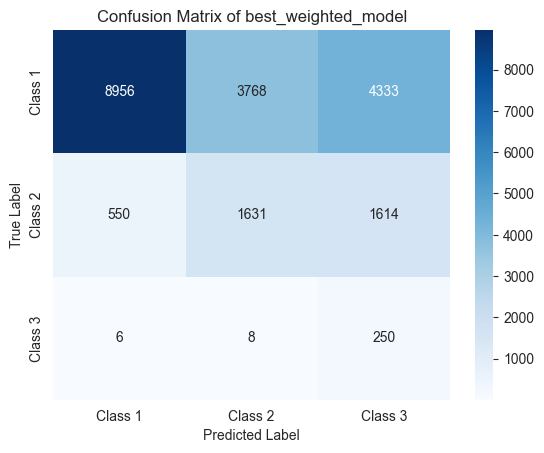

In [57]:
confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_train, y_train)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


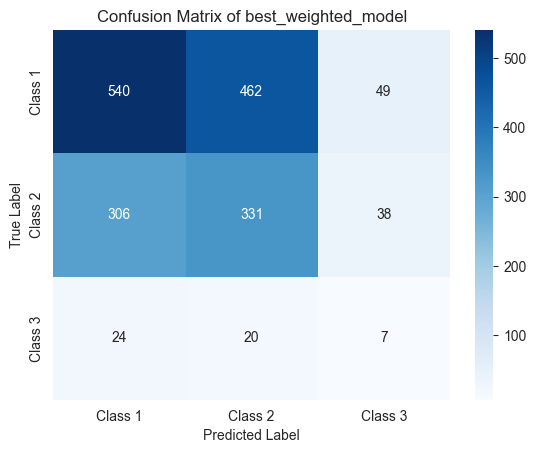

In [58]:
confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_val, y_val)